We start off by importing the libraries we need and loading two types of data - snapshots of model state at the end of the timestep (including from the coarsened high-res data), and tendencies. Nudging tendencies are output directly by the runfiles while the model is running. Physics tendencies are derived by us here from snapshots before and after physics is called.

**Note: Data can take a long time to load (~tens of minutes)**
Snapshots are mostly lazy-loaded, but contain many files, so the initial load can also take some time. Grid variables are eagerly loaded and take a long time.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import xarray as xr
import fsspec
import zarr
import vcm
import os
import fv3util
import vcm
import cartopy.crs
from datetime import datetime, timedelta

In [21]:
config = yaml.safe_load(open('../fv3config_base.yml', 'r'))
DATA_DIR_TEMPLATE = "gs://vcm-ml-data/mcgibbon-testing/outdir-{}h"
TIMESCALES = [1, 3, 6, 12, 24]
# stages = ['before_dynamics', 'after_dynamics', 'after_physics', 'after_nudging', 'nudging_tendencies', 'reference']
MODEL_STAGE = "after_nudging"
GRID_FILENAME_TEMPLATE = os.path.join(DATA_DIR_TEMPLATE.format(12), 'atmos_8xdaily.tile{}.nc')
RESTARTS_PATH = config['nudging']['restarts_path']
IO_LAYOUT = (1, 1)  # probably only runs for (1, 1)
PLOT_TRANSFORM = cartopy.crs.PlateCarree()

In [22]:
# load snapshot data

def get_timescale_label(timescale):
    if isinstance(timescale, int):
        return f"nudge-{timescale:02d}h"
    else:
        return f"nudge-{timescale:05.2f}"

snapshot = {}
fs, _, _ = fsspec.core.get_fs_token_paths(DATA_DIR_TEMPLATE)
for timescale in TIMESCALES:
    zarr_location = os.path.join(DATA_DIR_TEMPLATE.format(timescale), f"{MODEL_STAGE}.zarr")
    if not fs.isdir(zarr_location):
        raise ValueError(f"location {zarr_location} does not exist")
    snapshot[get_timescale_label(timescale)] = xr.open_zarr(zarr.storage.LRUStoreCache(fs.get_mapper(zarr_location), max_size=None))
zarr_location = os.path.join(DATA_DIR_TEMPLATE.format(timescale), f"reference.zarr")
if not fs.isdir(zarr_location):
    raise ValueError(f"location {zarr_location} does not exist")
snapshot["reference"] = xr.open_zarr(zarr.storage.LRUStoreCache(fs.get_mapper(zarr_location), max_size=None))

In [23]:
# load physics and nudging tendencies

NUDGING_SUFFIX = "_tendency_due_to_nudging"
TIMESTEP = timedelta(minutes=15)
nudging_tendencies = {}
physics_tendencies = {}
for timescale in TIMESCALES:
    nudging = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "nudging_tendencies.zarr")
            ),
            max_size=None
        )
    )
    rename_dict = {}
    for varname in nudging:
        if varname.endswith(NUDGING_SUFFIX):
            rename_dict[varname] = varname[:-len(NUDGING_SUFFIX)]
    nudging = nudging.rename(rename_dict)
    nudging_tendencies[get_timescale_label(timescale)] = nudging
    
    before_physics = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "after_dynamics.zarr")
            ),
            max_size=None
        )
    )
    after_physics = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "after_physics.zarr")
            ),
            max_size=None
        )
    )
    physics = xr.Dataset()
    for varname in nudging:
        if varname != 'time':
            physics[varname] = (after_physics[varname] - before_physics[varname]) / TIMESTEP.total_seconds()
    physics_tendencies[get_timescale_label(timescale)] = physics

In [8]:
# grid variables (latb in particular) are currently hard to acquire from the running model,
# but easy to grab from the diagnostic files

def load_grid():
    ntime, ntile, nz, ny, nx = snapshot['reference']['air_temperature'].shape
    lat = np.empty([ntile, ny, nx])
    latb = np.empty([ntile, ny+1, nx+1])
    lon = np.empty([ntile, ny, nx])
    lonb = np.empty([ntile, ny+1, nx+1])
    for tile in range(6):
        grid_filename = GRID_FILENAME_TEMPLATE.format(tile+1)
        with fsspec.open(grid_filename, mode='rb') as f:
            ds = xr.open_dataset(f)
            for name in ('lat', 'latb', 'lon', 'lonb'):
                locals()[name][tile, :, :] = ds[name].values
    return lat, lon, latb, lonb

lat, lon, latb, lonb = load_grid()
p = np.cumsum(np.mean(snapshot['reference']['pressure_thickness_of_atmospheric_layer'][0, :, :, :, :].values, axis=(0, 2, 3)))

Looking at maps of 500hPa vertical wind, we see a lot of tropical grid-scale convection which gets smoothed out/removed by the coarse model. Frontal regions are also significantly smoothed. Frontal convection is not clearly decreased overall - inspecting the difference map generally shows dipole (shifting) and tripole (damping/spreading) patterns. Regions of convection and subsidence are generally in the right areas, even at fairly long damping timescales (12h) after about 3 days.

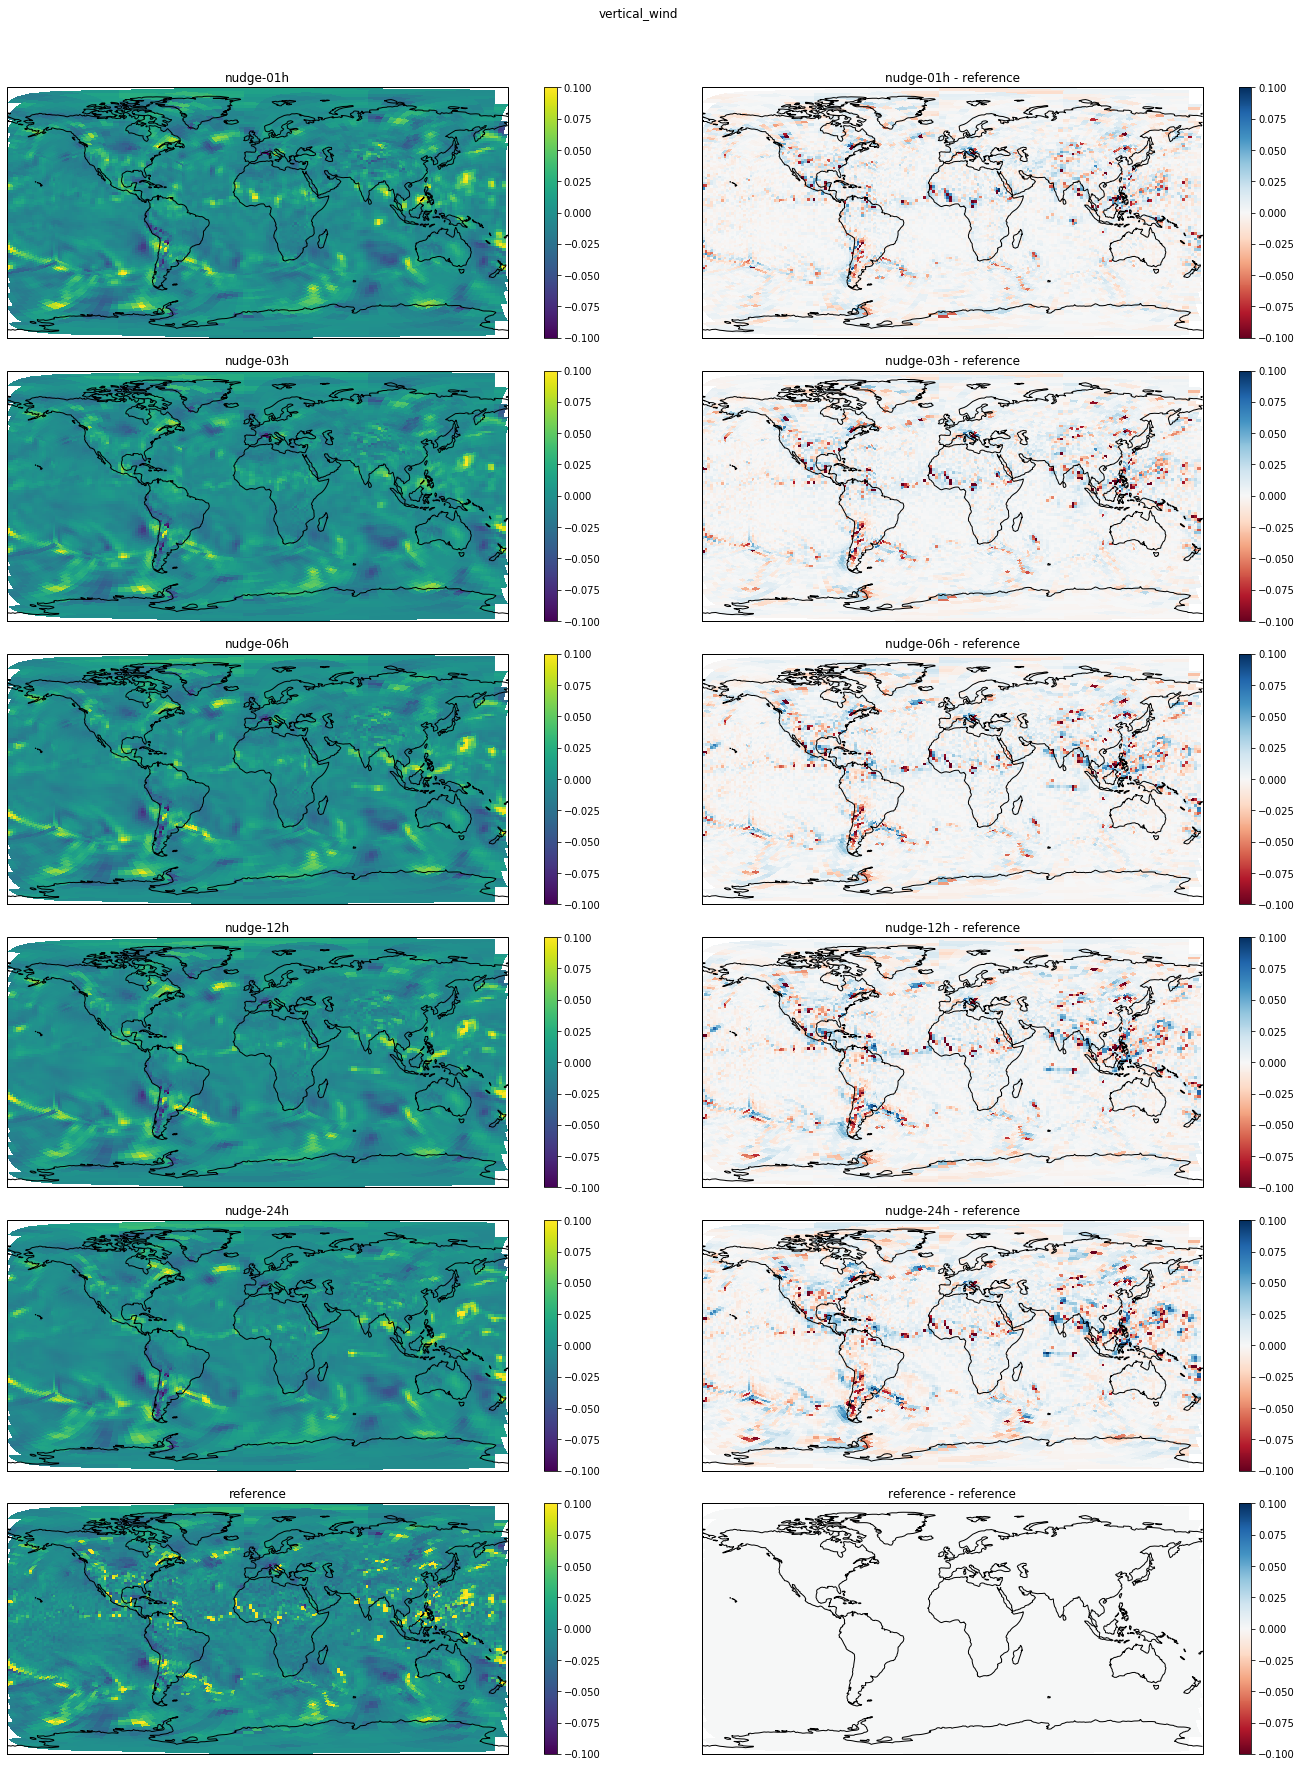

In [24]:
# can tweak these variables to look at different timesteps, vertical levels, and variables.

i_time = 5*24*4  # days * 24 hours * 4 timesteps per hour
p_target_hpa = 500
varname = "vertical_wind"
cmap_base = "viridis"
vmin_base = -0.1  # vmin and vmax for variable itself
vmax_base = 0.1
cmap_error = "RdBu"
vmin_error = -0.1  # vmin/vmax for error with respect to reference
vmax_error = 0.1


compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(20, 25)

fig, ax = plt.subplots(len(snapshot.keys()), 2, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(varname)

for i, key in enumerate(sorted(list(snapshot.keys()))):
    im = vcm.pcolormesh_cube(
        latb, lonb, snapshot[key][varname][i_time, :, iz].values, ax=ax[i, 0], vmin=vmin_base, vmax=vmax_base, cmap=cmap_base
    )
    ax[i, 0].set_title(key)
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    plt.colorbar(im, ax=ax[i, 0])
    im = vcm.pcolormesh_cube(
        latb, lonb, snapshot[key][varname][i_time, :, iz].values - snapshot['reference'][varname][i_time, :, iz].values, ax=ax[i, 1], vmin=vmin_error, vmax=vmax_error, cmap=cmap_error
    )
    ax[i, 1].set_title(f"{key} - reference")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    plt.colorbar(im, ax=ax[i, 1])

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Histogram of vertical velocity behaves very similarly to in [Noah's analysis of SAM](https://github.com/VulcanClimateModeling/uwnet/blob/0b167d4baff0d497df1ea2986a713c081ed90399/2020-02-20-w500-with-nudging.ipynb), except that downdrafts appear to be better represented. Particularly, we see lower occurence of very high vertical velocities, as a result of convective peaks being smeared out at coarser resolution.

Unlike in Noah's analysis, the strongest nudging timescale shows the lowest occurrence of peak vertical winds. The 1h timescale does have the highest standard deviation of 500hpa vertical wind, but only by a small margin, much smaller than in SAM.

I would take from this that the coarse model dynamics do not want to support the same features as the high-resolution model. If we want to reproduce these features in the coarse model, it may be worth integrating machine learning physics routines in-line in the dynamics, to represent the impact of subgrid-scale dynamics in producing grid-scale updrafts. These features appear to be very learn-able, occuring within existing updraft features.

Text(0, 0.5, '500 hPa vertical_wind rmse')

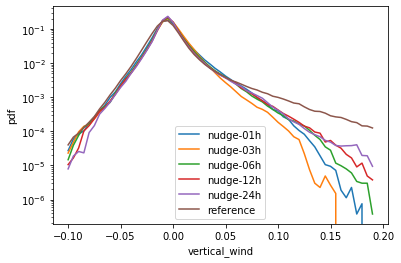

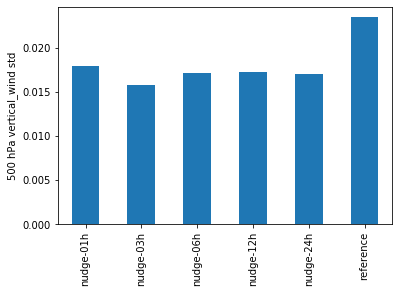

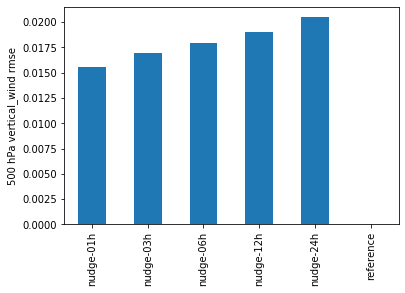

In [26]:
import pandas as pd

i_window = 4*24

def hist(x):
    w_bins = np.arange(-20,40) * .005
    counts = np.histogram(x, w_bins)[0]
    return pd.Series(counts/counts.sum(), index=w_bins[:-1])

df = pd.DataFrame({key: hist(snapshot[key][varname][i_time-i_window:i_time+i_window, :, iz, :, :].values) for key in snapshot.keys()})
df.plot(logy=True)

plt.ylabel('pdf')
plt.xlabel(f'{varname}')

plt.figure()
pd.Series({key: snapshot[key][varname][i_time-i_window:i_time+i_window, :, iz, :, :].values.std() for key in snapshot.keys()}).plot(kind="bar")
plt.ylabel(f"{p_target_hpa} hPa {varname} std")


plt.figure()
pd.Series({key: (
    snapshot[key][varname][i_time-i_window:i_time+i_window, :, iz, :, :].values -
    snapshot["reference"][varname][i_time-i_window:i_time+i_window, :, iz, :, :].values
).std() for key in snapshot.keys()}).plot(kind="bar")
plt.ylabel(f"{p_target_hpa} hPa {varname} rmse")

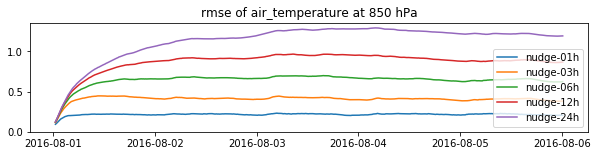

In [28]:
fig, ax = plt.subplots(figsize=(10, 2))
it_max = 5*24*4
varname = "air_temperature"
p_target_hpa = 850
iz = np.argmin(np.abs(p - p_target_hpa*100))
for key in sorted(list(snapshot.keys())):
    if key != 'reference':
        rmse = np.std(snapshot[key][varname][:it_max, :, iz, :, :].values - snapshot['reference'][varname][:it_max, :, iz, :, :].values, axis=(1, 2, 3))
        ax.plot(snapshot['nudge-01h']['time'][:it_max], rmse, label=key)
ax.legend(loc="lower right")
ax.set_title(f'rmse of {varname} at {p_target_hpa} hPa')
ax.set_ylim(0)
plt.show()

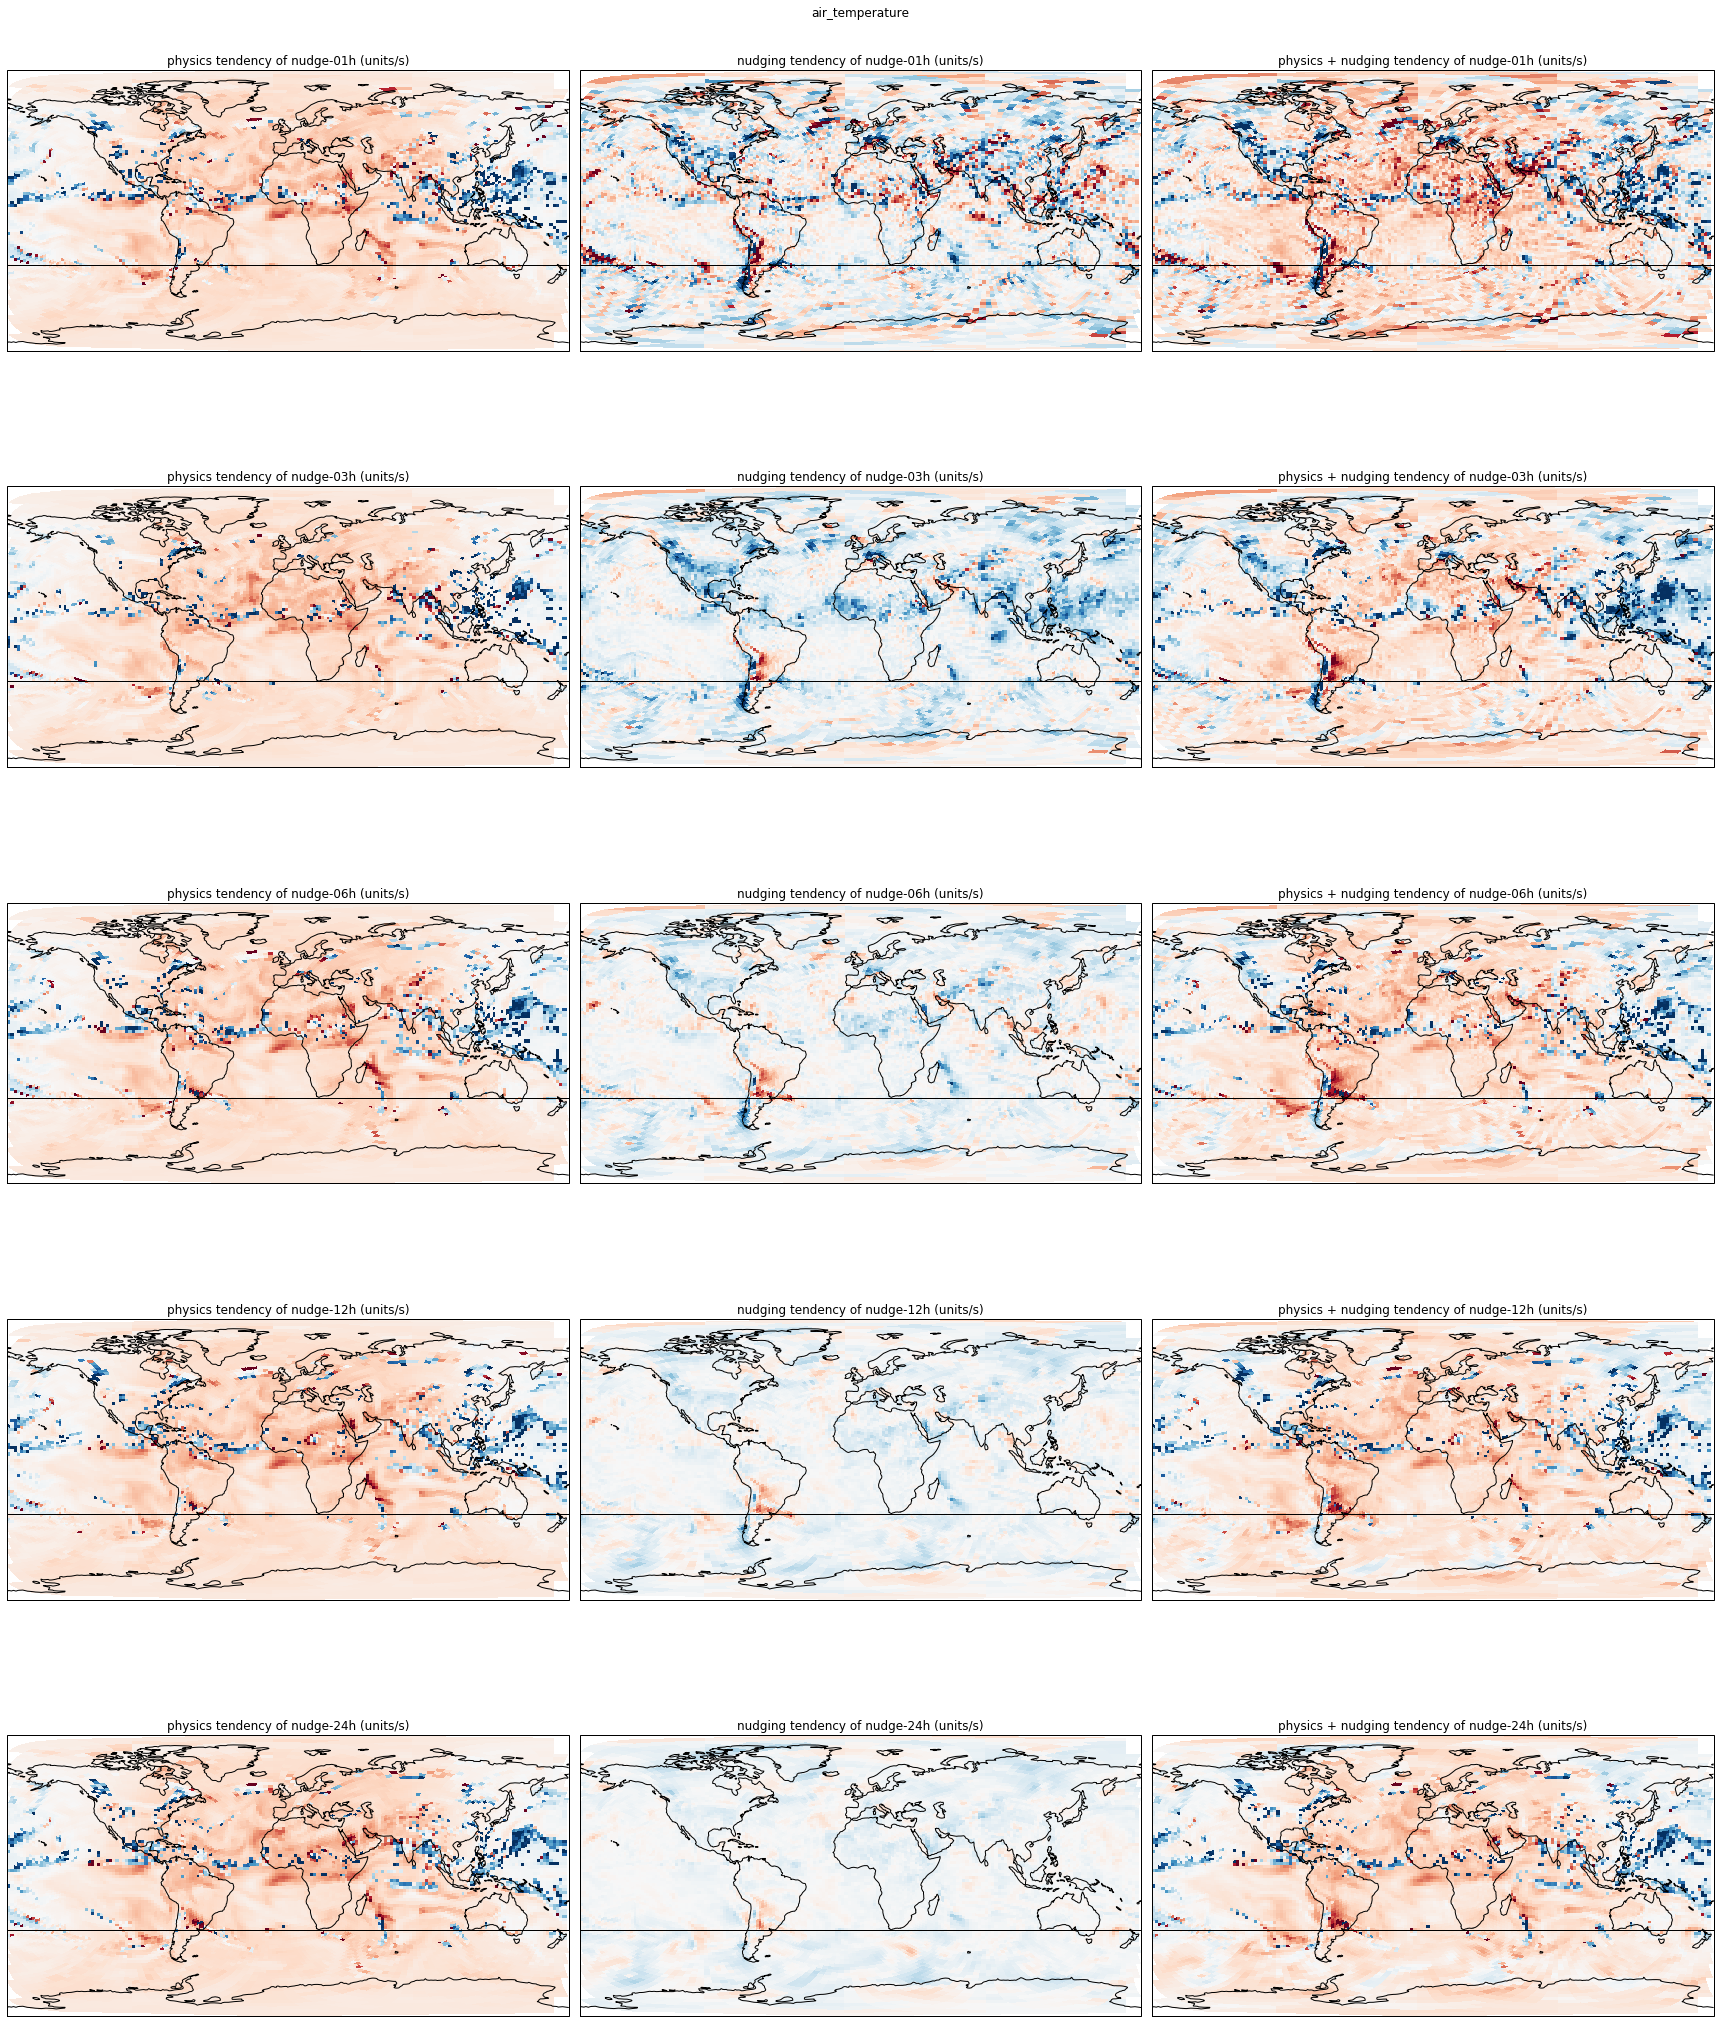

In [36]:
i_time = 5*24*4
p_target_hpa = 500
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 30)
varname = "air_temperature"
vmin=-1.5e-4
vmax=1.5e-4

lat_target = -35

fig, ax = plt.subplots(len(physics_tendencies.keys()), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(varname)

for i, key in enumerate(sorted(list(physics_tendencies.keys()))):
    im = vcm.pcolormesh_cube(
        latb, lonb, physics_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/s)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    im = vcm.pcolormesh_cube(
        latb, lonb, nudging_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/s)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, physics_tendencies[key][varname][i_time, :, iz].values + nudging_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"physics + nudging tendency of {key} (units/s)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()